## 주택가격 예측 : 회귀문제
- 분류문제 : 입력 데이터포인트의 개별적인 레이블 하나를 예측하는 것
- 회귀문제 : 개별적인 레이블 대신에 연속적인 값을 예측하는 회귀(regression)
  - 기상데이터가 주어졌을 때, 내일기온 예측 혹은 프로젝트 완료시기 예측 등
  - 로지스틱 회귀는 분류임

### 보스턴 주택 가격 데이터셋

In [34]:
# 데이터셋 로드
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

# 데이터 정규화
# 입력 데이터에 있는 각 특성에 대해 특성의 평균을 빼고 표준편차로 나눔
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [35]:
# 모델 정의하기
from keras import models, layers

In [41]:
def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### K-겹 검증하기(K-fold cross-validation)

In [37]:
import numpy as np

In [42]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [43]:
all_scores

[2.2034002648721827,
 2.5475721158603633,
 2.5830506499450987,
 2.3521636163834296]

In [44]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [46]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [47]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [48]:
import matplotlib.pyplot as plt

findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans.


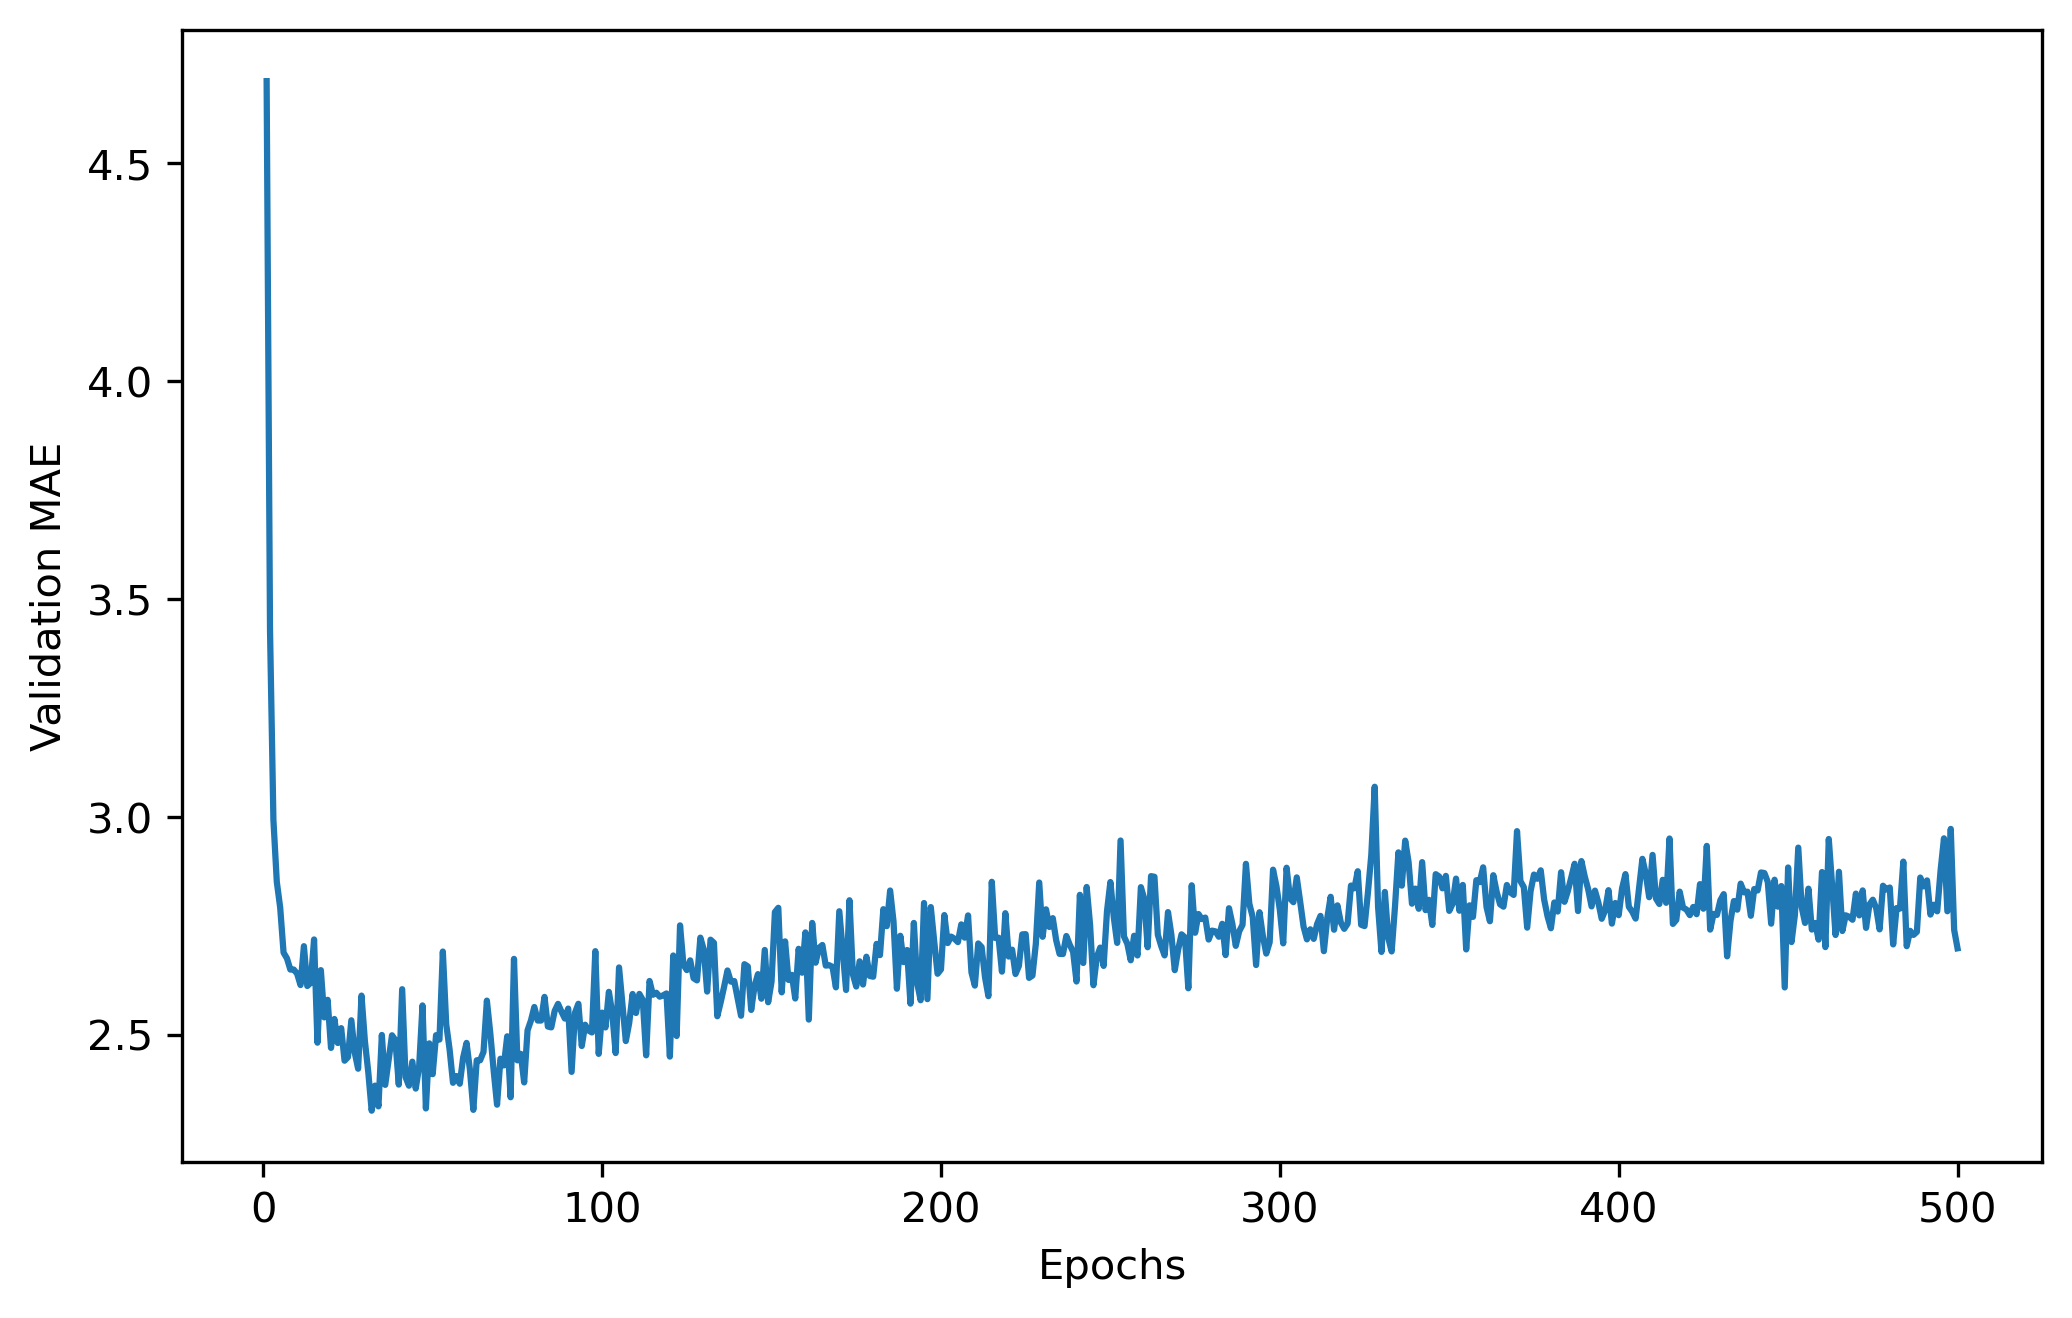

In [49]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [51]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

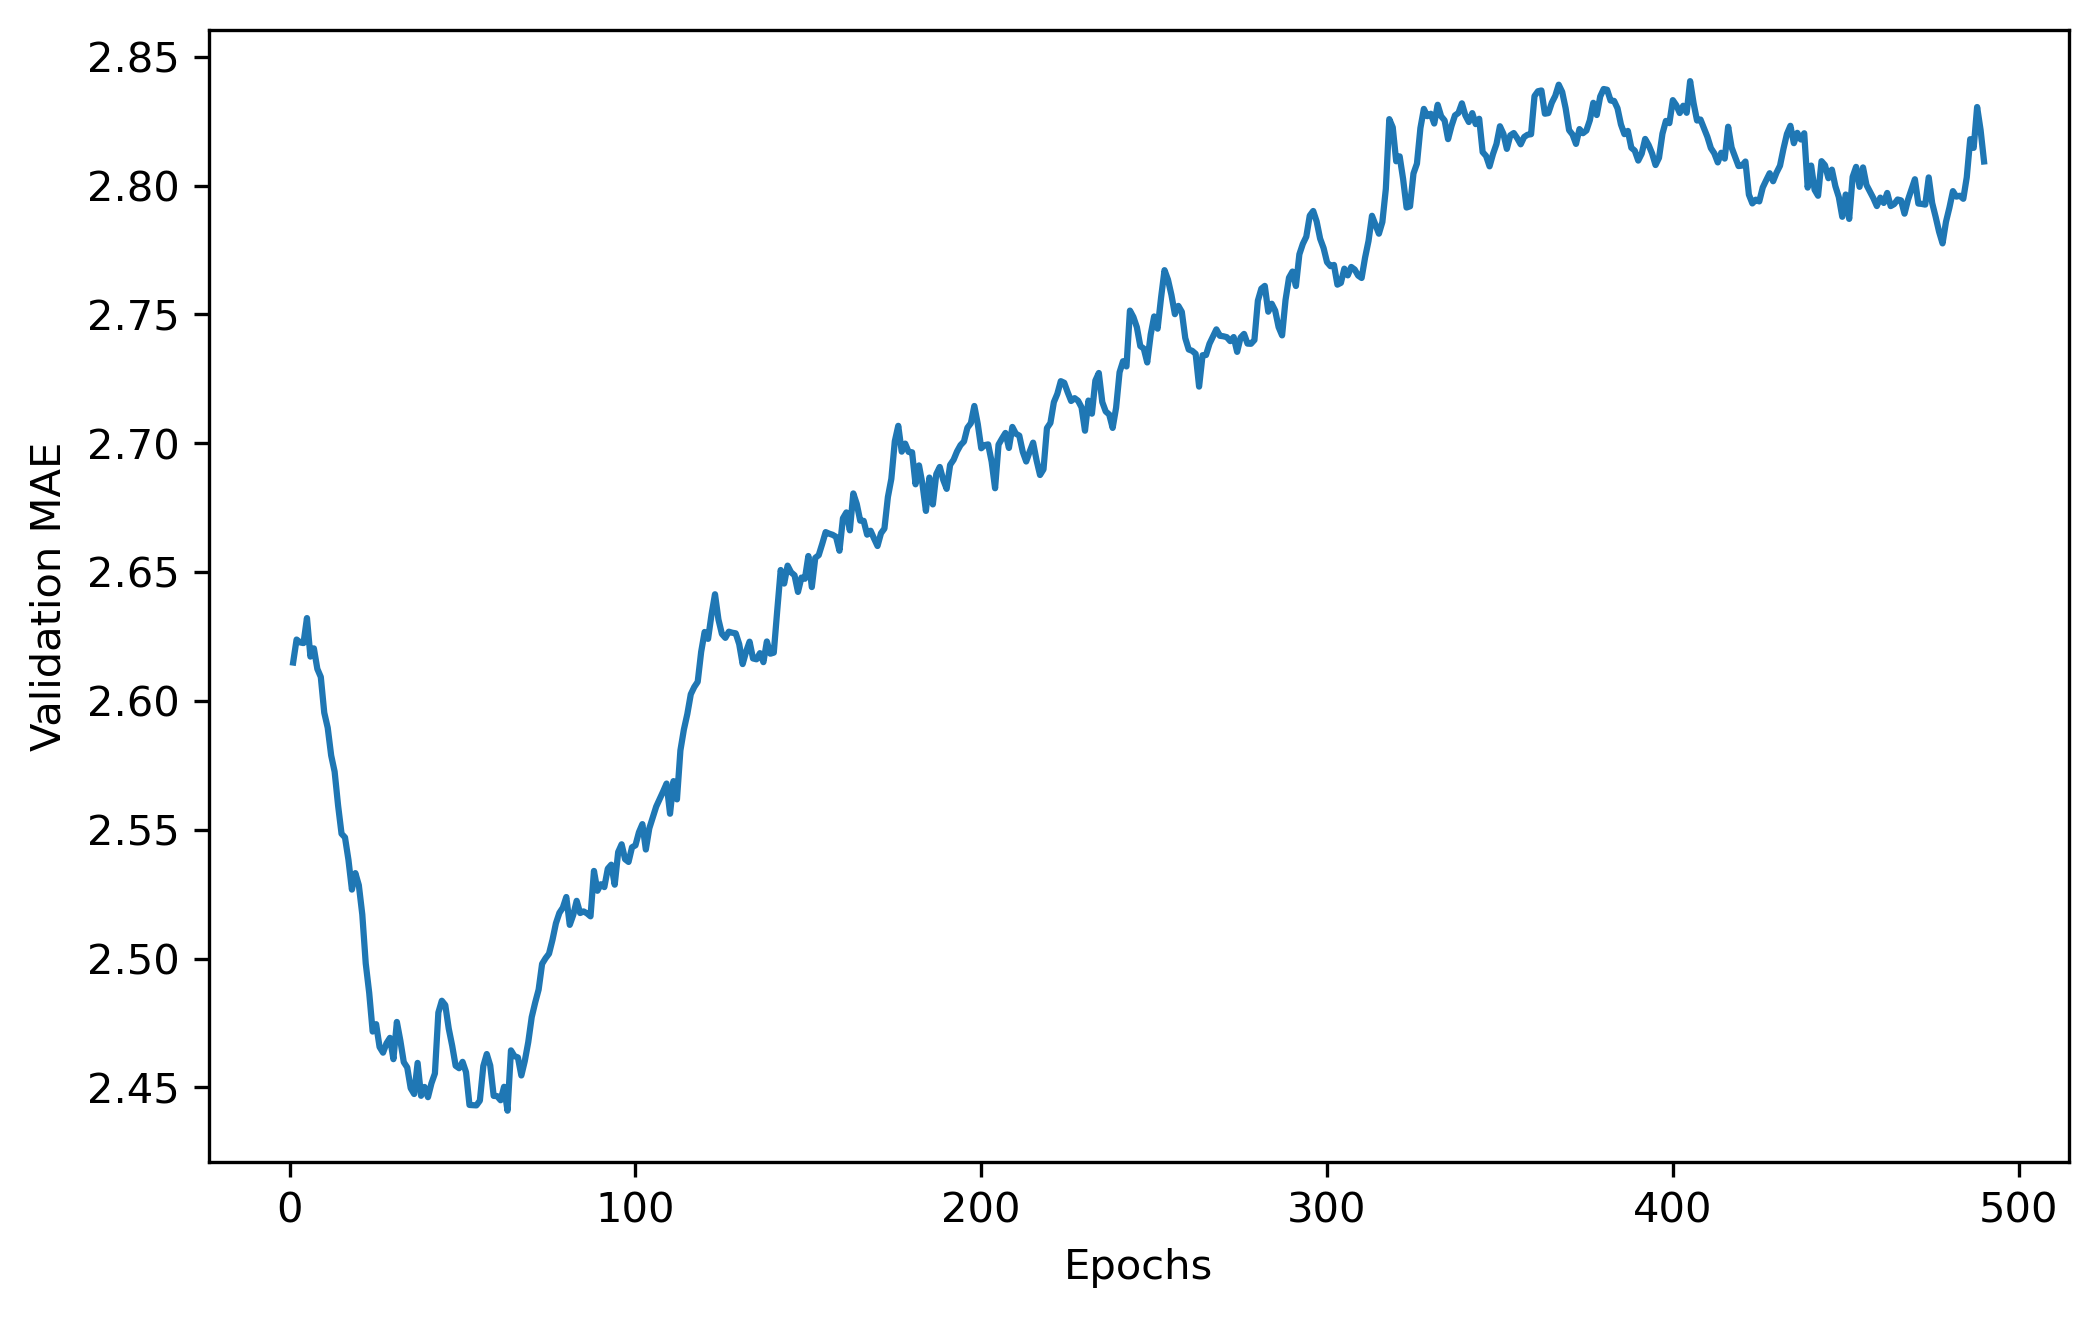

In [52]:
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [53]:
### 최종모델 훈련하기

model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 519us/step


In [54]:
test_mae_score

2.7235974424025593

## Summaray
- 회귀는 분류와 다르게 mse라는 손실함수를 사용함
- 일반적인 회귀지표는 평균 절대 오차(MAE)
- 가용한 데이터가 적다면 K-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 평가방법임
- 훈련데이터가 적다면, 과대적합 방지를 위해 은닉층 1개 또는 2개로 끝